## Purpose of the notebook
I have observed that there is a 1.5 day delay, on average, between the AKI diagnosis being entered in patient record and the clinical manifestation of AKI symptoms. The purpose of this notebook is to:
1. get grountruth labels for AKI - yes/no, using in hospital measurements criteria:
    a. creatinine level increases by 0.3mg/dL or more in 48 h
    b. creatinine level increases 1.5-fold compared to baseline within 7 days, I will take first available measure as baseline.
    c. urine output is less than 0.5mL/kg/hr in 6h
2. get the earliest possible offset of aki manifestation for the positive class
3. filter out patients who manifest aki before 24h

In [248]:
import pandas as pd
creat = pd.read_csv('../data/intermediate/creatinine_lev_all_3d.csv')
creat.columns=['patientunitstayid', 'labresult', 'labresultoffset']

In [83]:
creat.sort_values(by=['patientunitstayid', 'labresultoffset'], inplace=True)
len(creat.patientunitstayid.unique())

33176

In [249]:
creat['prev_labresult'] = creat.groupby(['patientunitstayid'])['labresult'].shift(1)
creat['delta'] = creat['labresult'] - creat['prev_labresult']

In [250]:
from datetime import datetime
startTime = datetime.now()

creat['labresultoffset'] = pd.to_timedelta(creat['labresultoffset'], unit='minute')
creat.set_index('labresultoffset', inplace=True)
creat['creat_2day_cum'] = creat.groupby('patientunitstayid')['delta'].apply(lambda x: x.rolling('2d').sum()) 
print(datetime.now() - startTime)

In [251]:
import math
import numpy as np
creat['creat_fold_change'] = creat['labresult']/creat['prev_labresult']
creat['creat_7day_inc'] = creat.groupby('patientunitstayid')['creat_fold_change'].apply(lambda x: x.rolling('7d').apply(np.prod))


In [252]:
creat.loc[creat['creat_2day_cum'] >= 0.3, 'AKI_reached_2d'] = 1
creat.loc[creat['creat_7day_inc'] >= 1.5, 'AKI_reached_7d'] = 1
creat.fillna(0, inplace=True)

In [88]:
creat['AKI_reached_2d'].sum()/len(creat)

0.10711792261609837

In [89]:
creat['AKI_reached_7d'].sum()/len(creat)

0.06828521237782081

In [254]:
creat.reset_index(inplace=True)
first_2d = creat[creat['AKI_reached_2d']==1].groupby('patientunitstayid')['labresultoffset'].first()
#first_2d = first_2d/pd.Timedelta('1 minute')
first_7d = creat[creat['AKI_reached_7d']==1].groupby('patientunitstayid')['labresultoffset'].first()
#first_7d = first_7d/pd.Timedelta('1 minute')
first_occur_comb = pd.concat([first_2d, first_7d], axis=1, ignore_index=False)
first_occur_comb.fillna(0, inplace=True)
first_occur_comb.columns = ['2d_first', '7d_first']
first_occur_comb.head()

,2d_first,7d_first
patientunitstayid,,
141462,3022.0,0.0
143466,1759.0,0.0
143518,1303.0,0.0
144173,711.0,1207.0
144770,4127.0,4127.0


In [259]:
min_val_list = []
for index, row in first_occur_comb.iterrows():
    min_val = min(row)
    if min_val==0:
        row_list = row.values.tolist()
        row_list.remove(min_val)
        min_val_list.append(row_list[0])
    else:
        min_val_list.append(min_val)


In [261]:
min_val_df = pd.DataFrame({'patientunitstayid':first_occur_comb.index, 'min_val': min_val_list})
min_val_df.set_index('patientunitstayid', inplace=True)
min_val_df.head()

,min_val
patientunitstayid,
141462,3022.0
143466,1759.0
143518,1303.0
144173,711.0
144770,4127.0


In [262]:
first_occur_comb = pd.concat([first_occur_comb, min_val_df], axis=1, ignore_index=False)
first_occur_comb

,2d_first,7d_first,min_val
patientunitstayid,,,
141462,3022.0,0.0,3022.0
143466,1759.0,0.0,1759.0
143518,1303.0,0.0,1303.0
144173,711.0,1207.0,711.0
144770,4127.0,4127.0,4127.0
...,...,...,...
3352065,1610.0,0.0,1610.0
3352336,759.0,759.0,759.0
3353094,473.0,0.0,473.0


(-10.0, 5.0)

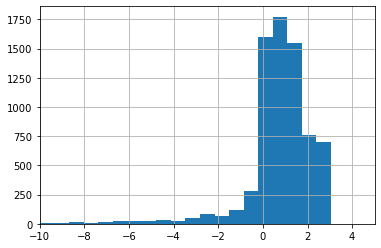

In [263]:
import matplotlib.pyplot as plt
first_occur_comb['min_val_days'] = first_occur_comb['min_val']/(60*24)
first_occur_comb['min_val_days'].hist(bins=100)
plt.xlim(-10, 5)

In [264]:
creat.set_index('patientunitstayid', inplace=True)
creat_4plot = creat[['labresultoffset', 'labresult']].merge(first_occur_comb['min_val'], left_index=True, \
                                                            right_index=True)
creat_4plot.dropna(inplace=True)
creat_4plot['detect_offset_h'] = (creat_4plot['labresultoffset'] - creat_4plot['min_val'])/60
creat_4plot['detect_offset_d'] = (creat_4plot['labresultoffset'] - creat_4plot['min_val'])/(60*24)
creat_4plot['detect_offset_d_round'] = round(creat_4plot['detect_offset_d'])
creat_4plot['detect_offset_h_round'] = round(creat_4plot['detect_offset_h'])


In [265]:
creat_4plot.reset_index('patientunitstayid', inplace=True)

creat_4plot_piv = creat_4plot[(creat_4plot['detect_offset_d_round']>=-5) & (creat_4plot['detect_offset_d_round']<=5)]
creat_4plot_piv = creat_4plot_piv[['patientunitstayid', 'labresult', \
                               'detect_offset_d_round']].pivot_table(values='labresult', index='detect_offset_d_round',\
                                                                     columns='patientunitstayid', \
                                                                     aggfunc='mean')

In [266]:
creat_4plot_piv

patientunitstayid,141462,143466,143518,144173,144770,144944,145467,145548,147615,148184,...,3351329,3351357,3351374,3351733,3351749,3352065,3352336,3353094,3353117,3353197
detect_offset_d_round,,,,,,,,,,,,,,,,,,,,,
-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.0,1.14,NaN,NaN,NaN,0.85,NaN,NaN,1.10,0.85,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960
-3.0,1.07,NaN,NaN,NaN,0.70,NaN,NaN,1.07,0.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.0,1.29,NaN,NaN,NaN,0.80,1.70,1.78,1.05,0.70,NaN,...,NaN,1.12,1.24,0.97,NaN,NaN,NaN,NaN,NaN,0.785
-1.0,1.34,1.93,1.71,NaN,NaN,1.96,1.70,NaN,1.00,NaN,...,1.51,1.17,1.33,NaN,NaN,6.74,0.83,NaN,NaN,0.920
0.0,1.47,2.42,2.14,1.742857,1.30,2.66,2.56,1.92,1.00,1.043333,...,3.10,1.86,1.82,1.36,1.41,7.31,1.39,1.415,1.18,1.340
1.0,NaN,2.20,2.11,2.925000,NaN,2.80,3.26,1.61,1.00,1.070000,...,3.84,3.87,1.64,0.94,3.13,6.73,1.39,1.270,1.75,NaN
2.0,NaN,NaN,1.73,3.500000,NaN,NaN,NaN,NaN,1.10,NaN,...,NaN,5.27,NaN,0.67,3.44,NaN,1.04,0.870,1.76,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN,NaN,NaN


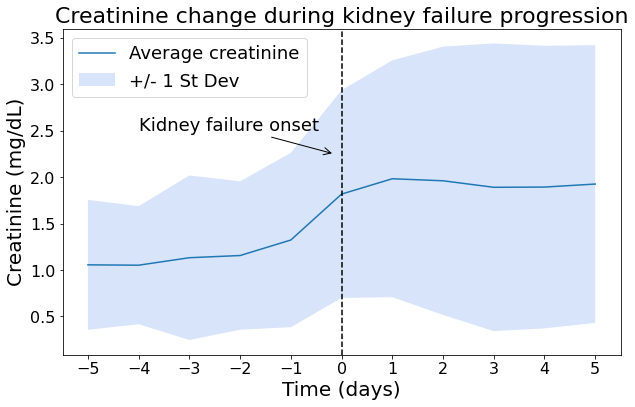

In [267]:
ave_daily = creat_4plot_piv.mean(axis=1)
std_daily = creat_4plot_piv.std(axis=1)
lower_bound = ave_daily-std_daily
upper_bound = ave_daily+std_daily
plt.figure(figsize=(10, 6))
ave_daily.plot(label='Average creatinine')
plt.fill_between(x=lower_bound.index, y1=lower_bound.values, y2=upper_bound.values, \
                 facecolor='cornflowerblue', alpha=0.25, label='+/- 1 St Dev')
plt.legend(loc='upper left', fontsize=18)
plt.ylabel('Creatinine (mg/dL)', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.title('Creatinine change during kidney failure progression', fontsize=22)
plt.axvline(0, ls='--', c='k')
plt.annotate('Kidney failure onset', xy=(-0.15, 2.25), xytext=(-4, 2.5), arrowprops=dict(arrowstyle="->"), \
            fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.savefig('../images/creat_kid_prog.png')

In [272]:
# number of positive cases
num_pos = len(first_occur_comb)
num_tot = len(creat.reset_index()['patientunitstayid'].unique())
fraction = round(num_pos/num_tot, 2)
print("Number of positive cases ", num_pos)
print("Total number of patients ", num_tot)
print("Fraction of positive cases ", fraction)

Number of positive cases  7215
Total number of patients  33176
Fraction of positive cases  0.22


### Although this is not the entire dataset, I expect to get similar ratios for the complete dataset. Next see if urine measurements provide similar results.

In [274]:
urine = pd.read_csv('../data/intermediate/urine_out_all_3d.csv')
urine.columns = ['patientunitstayid', 'intakeoutputoffset', 'cellvaluenumeric', 'celllabel']
print(len(urine))
urine.drop_duplicates(inplace = True) 
print(len(urine))

611987
611987


In [275]:
urine = urine.pivot_table(values='cellvaluenumeric', index=['patientunitstayid', 'intakeoutputoffset'], \
                          columns='celllabel', aggfunc='mean')
print(len(urine))

600612


In [276]:
urine.dropna(inplace=True)
print(len(urine))

11369


In [277]:
urine.columns = ['Bodyweight (kg)', 'Urine (mL)']
urine.reset_index(inplace=True)
urine['prev_intakeoutput'] = urine.groupby(['patientunitstayid'])['intakeoutputoffset'].shift(1)
urine.fillna(0, inplace=True)
urine['time_delta'] = urine['intakeoutputoffset'] - urine['prev_intakeoutput']

In [278]:
urine['ml/kg/h'] = (urine['Urine (mL)']/urine['Bodyweight (kg)']) / (urine['time_delta'].abs()/60)
urine['intakeoutputoffset'] = pd.to_timedelta(urine['intakeoutputoffset'], unit='minute')
urine.set_index('intakeoutputoffset', inplace=True)
urine['urine_6h_ave'] = urine.groupby('patientunitstayid')['ml/kg/h'].apply(lambda x: x.rolling('6h').mean()) 

In [279]:
urine.loc[urine['urine_6h_ave'] < 0.5, 'AKI_reached_6h'] = 1
urine['AKI_reached_6h'].fillna(0, inplace=True)

In [280]:
urine.reset_index(inplace=True)
urine_6h_first = urine[urine['AKI_reached_6h']==1].groupby('patientunitstayid')['intakeoutputoffset'].first()
urine_6h_first = urine_6h_first/pd.Timedelta('1 minute')
print(len(urine_6h_first))

5062


In [281]:
urine['patientunitstayid'].unique().shape

(6260,)

# I cannot use urine measurement info
80% of the data is missing. And out of 6260 patients for whom there is data 5062 appear to have developwd kidney injury. It is possible that there is a bias towards measuring the urine of at risk patients and some of the patient ids coincide with the ones identified from creatinine test. However, with so much missing data and very little information on negative patients this measure cannot be used. Especially since a single missed mea